In [231]:
# Initialize Otter
import otter
grader = otter.Notebook("assignment1.ipynb")

In [232]:
import matplotlib.pyplot as plt

# Assignment 1: 2018 US House Elections

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

## Direction and Goal

![election_prediction](images/clinton-trump-rating.png)  
[image credit](https://donsnotes.com/politics/images/clinton-trump-rating.png)

We haven't talked about predictive models, but we can still think about what makes a "good" prediction.  In this assignment, we'll focus on evaluating the quality of election predictions made by the website [fivethirtyeight.com](https://www.fivethirtyeight.com).  As one prominent example, fivethirtyeight predicted that Clinton had a 70.9% chance to win the election.  Was their model wrong?

To gain insight into questions like this, we'll focus on  [US House elections predictions from 2018](https://projects.fivethirtyeight.com/2018-midterm-election-forecast/house/).  Their predictions are based predominantly on polling data but include other sources as well (state of the economy, overall favoriability of politic parties, etc).  

This homework is based loosely on [this article](https://projects.fivethirtyeight.com/checking-our-work/).  Please read the article before beginning the assignment.

## Question 1: Data Processing

### Download Data
Command line interface is a useful tool for programmatically interacting with general functions of your computer: e.g. manipulate/manage files, download from the internet, run scripts, etc.

We will get acquainted with command line soon, but below uses command line interace commands to download the raw CSV file from [fivethirtyeight's github page for this data](https://github.com/fivethirtyeight/checking-our-work-data/blob/master/us_house_elections.csv). The `!` mark tells Jupyter notebook that the command following it is to be evaluated as a command line code.

In [233]:
!wget -nc https://raw.githubusercontent.com/fivethirtyeight/checking-our-work-data/master/us_house_elections.csv

File ‘us_house_elections.csv’ already there; not retrieving.



In [234]:
!ls -lF ## `ls` command verify that data is downloaded in our folder

total 24016
-rw-rw-r-- 1 jovyan users    52779 Oct 11 07:39 'assignment1(in progress).ipynb'
-rw-rw-r-- 1 jovyan users   112578 Oct 13 06:16  assignment1.ipynb
-rw-r--r-- 1 jovyan users    78669 Oct 13 06:16  assignment1.pdf
-rw-r--r-- 1 jovyan users   299740 Oct 13 06:16  assignment1.zip
drwxrwsr-x 2 jovyan users     4096 Sep 28 06:10  images/
drwxrwsr-x 2 jovyan users     4096 Sep 28 06:10  tests/
-rw-rw-r-- 1 jovyan users 24027649 Sep 28 06:10  us_house_elections.csv


### Read Data into Python

Numpy and Pandas is used to read in the csv file into python.

In [235]:
import pandas as pd
import numpy as np
election_data = pd.read_csv("us_house_elections.csv", low_memory=False)

Add column of zeros named `bin` to `election_data` (we will populate this column with meaningful data later) and `print` the first 10 rows of the `DataFrame` using `iloc`.

In [236]:
election_data.loc[: , "bin"] = 0
election_data.iloc[0:10] 
election_data.shape

(284020, 15)

Fivethirtyeight has three different prediction models: `lite`, `classic` and `deluxe`, which roughly incorporate an increasing number of assumptions.  In this assignment lets focus on evaluting the quality of the `classic` predictions.  You can read more about how the prediction models work [here](https://fivethirtyeight.com/methodology/how-fivethirtyeights-house-and-senate-models-work/).

Fivethirtyeight continuously updated their predictions as more polling data became available for each of the races.  Let's focus on the predictions a few months before the election, on August 11th, and on the morning of election day, November 6th.  

### Question 1a: Subset Data

<!--
BEGIN QUESTION
name: q1a
manual: false
points: 5
-->

Create a new pandas dataframe called `election_sub` by filtering to include only rows in which the `forecast_type` is "classic", and the date of the foreceast (`forecast_date`) is 8/11 or 11/6. 

Using `query` method seems well-suited.  Note you can make two (or more) calls to `query` by chaining calls to `query` like this: `election_data.query(...).query(...)`. Output of one query will be used as an input to the second query.

In [237]:
election_sub = election_data.query("forecast_type == 'classic'").query("forecast_date == ['2018-08-11','2018-11-06']")


In [238]:
grader.check("q1a")

q1a passed!

### Question 1b: Filtering Data

In previous question, data was subset for two forcast dates: 2018-11-06 and 2018-08-11. Presumably, there _should be_ two rows (predictions) for each candidate; however, you will see that some candidates are missing one of the two predictions and not all name entries are valid.

Using Pandas, remove any NaN names and any candidate that does not have two predictions.

Finally, overwrite `election_sub` with the filtered data.

There are different ways of doing this. I found the following functions useful:

* [`pandas.DataFrame.isnull`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isnull.html)
* [`pandas.DataFrame.groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)
* [`pandas.core.groupby.DataFrameGroupBy.filter`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.DataFrameGroupBy.filter.html)
* [`pandas.DataFrame.shape`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shape.html)

When using the documentation, make sure to use the correct version. You can check by running `pd.__version__`.

<!--
BEGIN QUESTION
name: q1b
manual: false
points: 3
-->

In [239]:
election_sub = election_sub[~election_sub['candidate'].isnull()].groupby('candidate').filter(lambda x : x.shape[0]==2)

In [240]:
grader.check("q1b")

q1b passed!

### Question 1c: Transform Data

<!--
BEGIN QUESTION
name: q1c
manual: false
points: 3
-->

We want to check whether events predicted by 538 to occur with probability _close to_ X% actually occured about X% of the time.  To do this, we have to define _close_.

First, we'll define the `cut_points` as 20 equally spaced numbers between 0 and 1 using `np.linspace`.  Then we'll group the predicted probabilities into the `19` equally spaced bins determined by those cut points.  Define the bin for each observation using the `pd.cut` function on the `probwin` variable.  Then, assign the result to column `bin` of `election_sub`. Use `include_lowest=True` when calling `pd.cut`.

_Note: Can you spot the strange behavior of `include_lowest=True`? [Despite the output, `pd.cut` seems to work correctly](https://github.com/pandas-dev/pandas/issues/23164#issuecomment-510700455)_

In [241]:
cut_points = np.linspace (0 , 1, 20)
election_sub['bin'] = pd.cut(election_sub['probwin'],cut_points,include_lowest='TRUE')
election_sub

,year,office,state,district,special,election_date,forecast_date,forecast_type,party,candidate,projected_voteshare,actual_voteshare,probwin,probwin_outcome,bin
4,2018,House,WY,1.0,False,2018-11-06,2018-11-06,classic,D,Greg Hunter,31.33293,NaN,0.00032,0,"(-0.001, 0.0526]"
5,2018,House,WY,1.0,False,2018-11-06,2018-11-06,classic,R,Liz Cheney,63.15379,NaN,0.99968,1,"(0.947, 1.0]"
10,2018,House,WV,3.0,False,2018-11-06,2018-11-06,classic,D,Richard Neece Ojeda,44.29584,NaN,0.07366,0,"(0.0526, 0.105]"
11,2018,House,WV,3.0,False,2018-11-06,2018-11-06,classic,R,Carol Devine Miller,55.70416,NaN,0.92634,1,"(0.895, 0.947]"
18,2018,House,WV,2.0,False,2018-11-06,2018-11-06,classic,D,Talley Sergent,43.09996,NaN,0.06562,0,"(0.0526, 0.105]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253850,2018,House,AL,2.0,False,2018-11-06,2018-08-11,classic,R,Martha Roby,58.46975,NaN,0.97574,1,"(0.947, 1.0]"
253855,2018,House,AL,1.0,False,2018-11-06,2018-08-11,classic,D,Robert Kennedy,34.87751,NaN,0.00046,0,"(-0.001, 0.0526]"
253856,2018,House,AL,1.0,False,2018-11-06,2018-08-11,classic,R,Bradley Byrne,65.12249,NaN,0.99954,1,"(0.947, 1.0]"
253861,2018,House,AK,1.0,False,2018-11-06,2018-08-11,classic,D,Alyse S. Galvin,43.98304,NaN,0.27064,0,"(0.263, 0.316]"


In [242]:
grader.check("q1c")

q1c passed!

## Question 2: Looking for Insights

### Question 2a: Calculate Change in Support

Let's see if we can find the candidates whose standings change the most between August 11 and November 6: one with largest improvement and another with largest decrease in win-probability. First, use the `agg` function calculate the difference.

Following functions have been useful for me:

* [`numpy.diff`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.diff.html)
* [`pandas.DataFrame.sort_values`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)
* [`pandas.DataFrame.groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)
* [`pandas.DataFrame.agg`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html): especially, [different functions to columns](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#applying-different-functions-to-dataframe-columns) 

Save the resulting DataFrame from `agg()` to a variable, `probwin_change`. 

<!--
BEGIN QUESTION
name: q2a
manual: false
points: 5
-->

In [243]:
probwin_change = election_sub.sort_values(by=['candidate','forecast_date']).groupby('candidate').agg({ 'probwin':np.diff })


In [244]:
probwin_change

,probwin
candidate,
A. Donald McEachin,0.00040
Aaron Andrus,0.00010
Aaron Swisher,-0.00228
Abby Finkenauer,0.08214
Abigail Spanberger,0.11884
...,...
Young Kim,-0.11342
Yvette Clarke,0.00000
Yvette Herrell,-0.18702


In [245]:
grader.check("q2a")

q2a passed!

### Question 2b: Looking for Largest Changes

Now, save the name of the candidates to string variables `rising_candidate` (largest increase) and `falling_candidate` (largest decrease).

* [`pandas.DataFrmae.idxmax`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmax.html)
* [`pandas.DataFrmae.idxmin`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmin.html)

<!--
BEGIN QUESTION
name: q2b
manual: false
points: 3
-->

In [246]:
rising_candidate = probwin_change.idxmax()
rising_candidate = rising_candidate[0]
falling_candidate = probwin_change.idxmin()
falling_candidate = falling_candidate[0]

In [247]:
falling_candidate , rising_candidate

('Kevin Yoder', 'Sharice Davids')

In [248]:
grader.check("q2b")

q2b passed!

<!-- BEGIN QUESTION -->

### Question 2c: Verify Outcome

Did the candidate win or lose the election? Verify with election outcome.
<!--
BEGIN QUESTION
name: q2c
manual: true
points: 5
-->

In [249]:
election_sub[election_sub['candidate'].isin([falling_candidate, rising_candidate]) ]

,year,office,state,district,special,election_date,forecast_date,forecast_type,party,candidate,projected_voteshare,actual_voteshare,probwin,probwin_outcome,bin
1890,2018,House,KS,3.0,False,2018-11-06,2018-11-06,classic,D,Sharice Davids,51.85115,NaN,0.84994,1,"(0.842, 0.895]"
1892,2018,House,KS,3.0,False,2018-11-06,2018-11-06,classic,R,Kevin Yoder,45.18069,NaN,0.15006,0,"(0.105, 0.158]"
252855,2018,House,KS,3.0,False,2018-11-06,2018-08-11,classic,D,Sharice Davids,44.84660,NaN,0.19566,1,"(0.158, 0.211]"
252857,2018,House,KS,3.0,False,2018-11-06,2018-08-11,classic,R,Kevin Yoder,51.78531,NaN,0.80426,0,"(0.789, 0.842]"


_The biggest riser (Sharice Davids) won the election, while the largest faller (Kevin Yoder) lost the election._

<!-- END QUESTION -->



## Prediction vs Actual Outcomes

<!-- BEGIN QUESTION -->

### Question 3a: Prediction Histogram

Make a histogram showing the predicted win probabilities _on the morning of the election._  Again, restrict yourself to only the `classic` predictions.

<!--
BEGIN QUESTION
name: q3a
manual: true
points: 5
-->

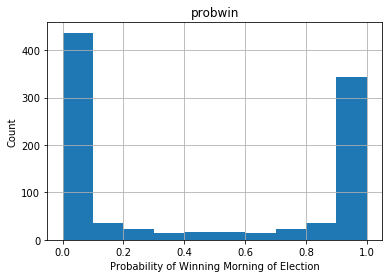

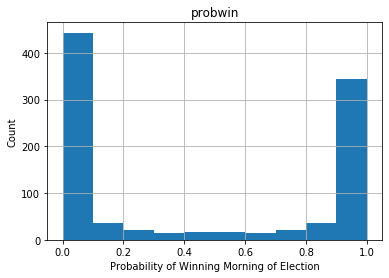

In [250]:
election_hist=election_sub.query("forecast_date == '2018-11-06'")
election_hist2=election_data.query("forecast_type == 'classic'").query("forecast_date == '2018-11-06'")
probwin_hist= election_hist.hist('probwin', bins=10)
plt.xlabel('Probability of Winning Morning of Election')
plt.ylabel('Count')
probwin_hist2= election_hist2.hist('probwin', bins=10)
plt.xlabel('Probability of Winning Morning of Election')
plt.ylabel('Count')
plt.show()


_*Note that the election_sub data frame and the original election_data data frame were both plotted with similar results_

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b: Prediction difficulty 

Are most house elections easy to forecast or hard to forecast? State your reasoning.

<!--
BEGIN QUESTION
name: q3b
manual: true
points: 5
-->

_House predictions are easy to forecast. We can see this by the fact that most win probabilities on the day of the election were either very close to 0 or very close to 1. Since there isn't many win predictions between these two values, this tells us it is pretty easy to forecast house elections._ 


<!-- END QUESTION -->

### Question 4a: Compute Actual Outcomes

Now we've grouped the observations into a discrete set of bins according to the predicted probability, `probwin`.  Within each bin, we now want to compute the actual fraction of times the candidates won.

If 538 did a good job, it will be close to the predited probabilities.  You'll need to use the `groupby` function to compute the mean of `probwin_outcome` (1 is a win and 0 is a loss) within each bin. Once again you can use `agg` method here.  

Save the fraction of actual wins in each bin in a list called `fraction_outcome`.

<!--
BEGIN QUESTION
name: q4a
manual: false
points: 5
-->

In [251]:
fraction_outcome = election_sub.groupby('bin').agg({'probwin_outcome':np.mean })
fraction_outcome

,probwin_outcome
bin,
"(-0.001, 0.0526]",0.001186
"(0.0526, 0.105]",0.062500
"(0.105, 0.158]",0.023810
"(0.158, 0.211]",0.142857
"(0.211, 0.263]",0.200000
"(0.263, 0.316]",0.058824
"(0.316, 0.368]",0.235294
"(0.368, 0.421]",0.272727
"(0.421, 0.474]",0.466667


In [252]:
grader.check("q4a")

q4a passed!

### Question 4b: Preparing to Present Results

<!--
BEGIN QUESTION
name: q4b
manual: false
points: 5
-->

For this problem we'll make a plot of the predicted probabilities and actual fraction of wins in each bin.  We've already computed the actual fraction of wins; all that remains is to plot it against the predicted value assocaited with each bin.

For the predicted value in each bin, using the midpoint of the bin would make sense.  Compute the midpoints of each bin from `cut_points`.

In [253]:
midpoints = cut_points[:-1] + np.diff(cut_points) / 2

In [254]:
grader.check("q4b")

q4b passed!

<!-- BEGIN QUESTION -->

### Question 4c: Visualize Results

<!--
BEGIN QUESTION
name: q4c
manual: true 
points: 5
-->

Now make a scatterplot using `midpoints` as the x variable and `fraction_outcome` as the y variable.  Draw a dashed line from `[0,0]` to `[1,1]` to mark the line y=x.  

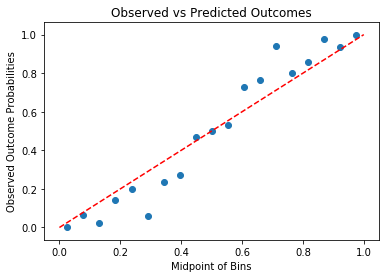

In [255]:
# magic for showing figures inline
%matplotlib inline 
import matplotlib.pyplot as plt

plt.scatter(midpoints,fraction_outcome)
plt.plot([0,1], [0,1] , linestyle='dashed', c='red')
plt.xlabel('Midpoint of Bins')
plt.ylabel('Observed Outcome Probabilities')
plt.title('Observed vs Predicted Outcomes');

<!-- END QUESTION -->



## Quantifying Uncertainty

### Question 5a: Model-based Error Estimation

If you did things correctly, it should look like fivethirtyeight has done "pretty" well with their forecasts: the actual fraction of wins tracks closely with the predicted number.

But how do we decide what's "good enough"? Consider this example: I correctly predict that a coin is fair (e.g. that it has a 50% chance of heads, 50% chance of tails).  But if I flip it 100 times, I can be pretty sure it won't come up heads exactly 50 times.  The fact that heads didn't come up exactly 50 times doesn't make my prediction incorrect.

To assess how reasonable the predictions are, I need to quantify the uncertainty in my estimate.  It's reasonable to assume that within each bin, $k$, the observed number of wins, $Y_k \sim \text{Binomial}\,(n_k, p_k)$, where $n_k$ is the number of elections and $p_k$ is the predicted win probability in bin $k$.

Classical results tell us that the obseved fraction of wins in bin $k$, $\hat p = \frac{Y_k}{n_k}$ has variance Var$\left(\hat p_k\right) = \frac{p_k (1-p_k)}{n_k} \approx \frac{\hat p_k(1- \hat p_k)}{n_k}$.  The standard deviation of the Binomial proportion then is $\hat \sigma_k \approx \sqrt{\frac{\hat p_k(1- \hat p_k)}{n_k}}$.  

If we use the [normal approximation to generate a confidence interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Normal_approximation_interval), then the 95% interval has the form $\hat p_k \pm 1.96 \hat \sigma_k$.

Create a new "aggregated" dataframe named `election_agg`.  Take `election_sub`, group by `bin` and compute both the average of the `probwin_outcome` (`mean`) and the number of observations in each bin (`count`) using the `agg` function.  Call this new data frame, `election_agg`.

THen, use the `mean` and `count` columns of `election_agg` to create a new column of `election_agg` titled `err`, which stores $1.96 \times \hat \sigma_k$ in each bin $k$.

<!--
BEGIN QUESTION
name: q5a
manual: false
points: 3
-->

In [256]:
election_agg = election_sub.groupby('bin',as_index='false').agg({'probwin_outcome':[np.mean ,'count']})
election_agg.columns=['mean','count']
election_agg["err"]=election_agg['mean'] * (1.0-election_agg['mean'])
election_agg["err"]=election_agg["err"] / election_agg["count"]
election_agg['err'] = election_agg["err"] **(1/2)
election_agg['err'] =(1.96 * election_agg["err"])

In [257]:
election_agg


,mean,count,err
bin,,,
"(-0.001, 0.0526]",0.001186,843,0.002324
"(0.0526, 0.105]",0.062500,32,0.083870
"(0.105, 0.158]",0.023810,42,0.046108
"(0.158, 0.211]",0.142857,28,0.129615
"(0.211, 0.263]",0.200000,30,0.143138
"(0.263, 0.316]",0.058824,17,0.111852
"(0.316, 0.368]",0.235294,17,0.201644
"(0.368, 0.421]",0.272727,22,0.186105
"(0.421, 0.474]",0.466667,15,0.252472


In [258]:
grader.check("q5a")

q5a passed!

<!-- BEGIN QUESTION -->

### Question 5b: Visualize Error Bars 1

Use `plt.errorbar` to create a new plot with error bars associated with the actual fraction of wins in each bin.  Again add a dashed y=x line.  Set the argument `fmt='.'` to create a scatterplot with errorbars.

<!--
BEGIN QUESTION
name: q5b
manual: true
points: 5
-->

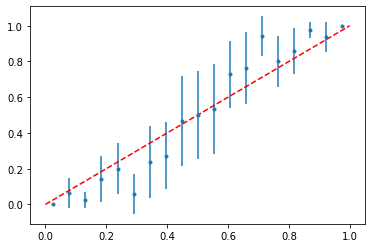

In [259]:
# Plotting code below
plt.errorbar(midpoints , fraction_outcome['probwin_outcome'] , yerr = election_agg['err'],fmt='.')
plt.plot([0,1], [0,1] , linestyle='dashed', c='red')

<!-- END QUESTION -->

### Question 5c: Computing Coverage

If our intervals were true 95% confidence intervals, then we would expect about 95% of them to cover the midpoint of the bin (i.e. overlap with the y=x line).

What fraction of the 95% confidence intervals cover the bin midpoint?  Create a variable, `upper`, to be the `mean` + `err` and another, `lower`, to be `mean` - `err` (both `upper` and `lower` should pandas series). Next, compute `frac_covering` as the fraction of midpoints between `lower` and `upper`. 

<!--
BEGIN QUESTION
name: q5c
manual: false
points: 5
-->

In [260]:
upper = election_agg['mean'] + election_agg['err']
lower = election_agg['mean'] - election_agg['err']
frac_covering = sum((midpoints > lower) & (midpoints < upper)) / len(midpoints) 

In [261]:
grader.check("q5c")

q5c passed!

<!-- BEGIN QUESTION -->

### Question 5d: Understanding Confidence Intervals

Are the 95% confidence intervals generally larger or smaller for more confident predictions (e.g. the predictions closer to 0 or 1).  What are the factors that determine the length of the confidence intervals?

<!--
BEGIN QUESTION
name: q5d
manual: true
points: 5
-->

_The confidence intervals for more confident predictions (predictions closer to 0 or 1) are generally smaller than the rest of the confidence intervals. This is due to the fact that the length is determined by the $1.96 \hat \sigma_k$ term. We use $\hat \sigma_k \approx \sqrt{\frac{\hat p_k(1- \hat p_k)}{n_k}}$ to estimate our $\hat \sigma_k$ term. From this we see that the term is greatly affected by $\frac{1}{n_k}$ where $n_k$ is the number of occurences we see within a given bin. From the previous histogram we created in part 3A we saw that the bulk of the observations were close to 0 or 1. As a result the $n_k$ for these two values is the largest which leads to a smaller $\sigma_k$ term and a smaller confidence interval._

<!-- END QUESTION -->



_Intentionally Blank_

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [262]:
grader.check_all()

q1a passed!

q1b passed!

q1c passed!

q2a passed!

q2b passed!

q4a passed!

q4b passed!

q5a passed!

q5c passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [263]:
# Save your notebook first, then run this cell to export your submission.
grader.export()